In [ ]:
from fastai import *
from fastai.vision.all import *

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data prep

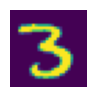

In [3]:
from pathlib import Path

path = Path.home() / ".fastai" / "data" / "mnist_sample"

im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

t_im3 = tensor(im3)

## Convolution from scratch - top edge kernel

In [25]:
def apply_kernel(img: tensor, kernel: tensor, r, c):
    return (img[r-1:r+2, c-1:c+2] * kernel).sum()

<Axes: >

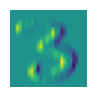

In [26]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

c_img = tensor( [[apply_kernel(t_im3, left_edge, r, c) for c in range(1,27)] for r in range(1,27) ] )
show_image(c_img)

## Convolutions in PyTorch 

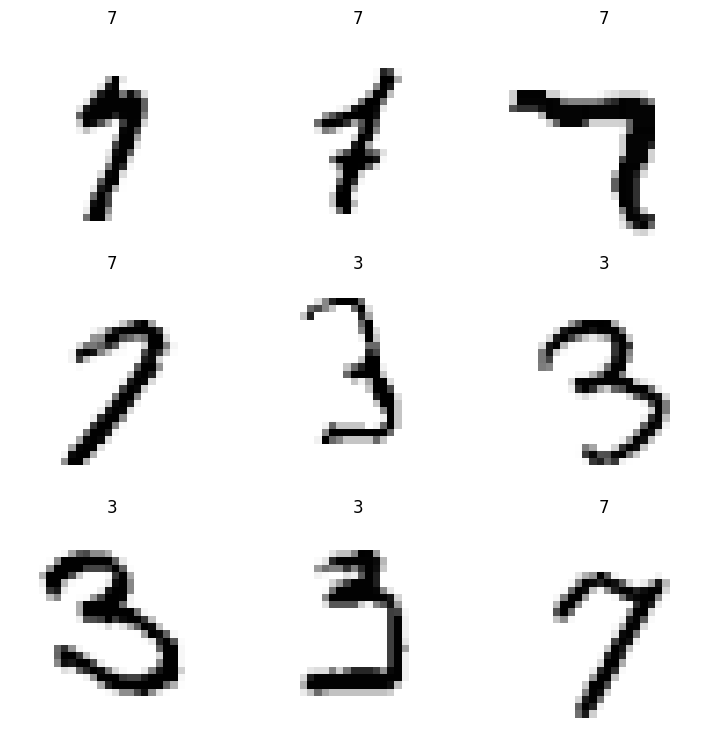

In [5]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
dls.show_batch()

In [6]:
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

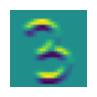

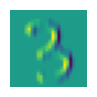

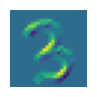

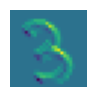

In [7]:
edge_kernels = torch.stack([top_edge, left_edge, diag1_edge, diag2_edge])
edge_kernels = edge_kernels.unsqueeze(1).cuda()

batch_features = F.conv2d((xb), edge_kernels)
for i in range(len(edge_kernels)):
    show_image(batch_features[0,i])

## Convolutional NN

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [12]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
).cuda()

xb.shape, broken_cnn(xb).shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

In [74]:
def conv(n_inputs, n_outputs, ks=3, act=True):
    layers = [nn.Conv2d(
        n_inputs, 
        n_outputs, 
        stride=2, 
        kernel_size=ks, 
        padding=ks//2
    )]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(n_outputs))
    return nn.Sequential(*layers).cuda()

In [75]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
).cuda()

simple_cnn(xb).shape

torch.Size([64, 2])

In [76]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [22]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [23]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.067796,0.029515,0.991168,00:40
1,0.020882,0.023453,0.992149,00:38


## Scaling up to recognizing 10 digits

In [ ]:
path = untar_data(URLs.MNIST)

# path = Path('C:/Users/marcinzi/.fastai/data/mnist_png')

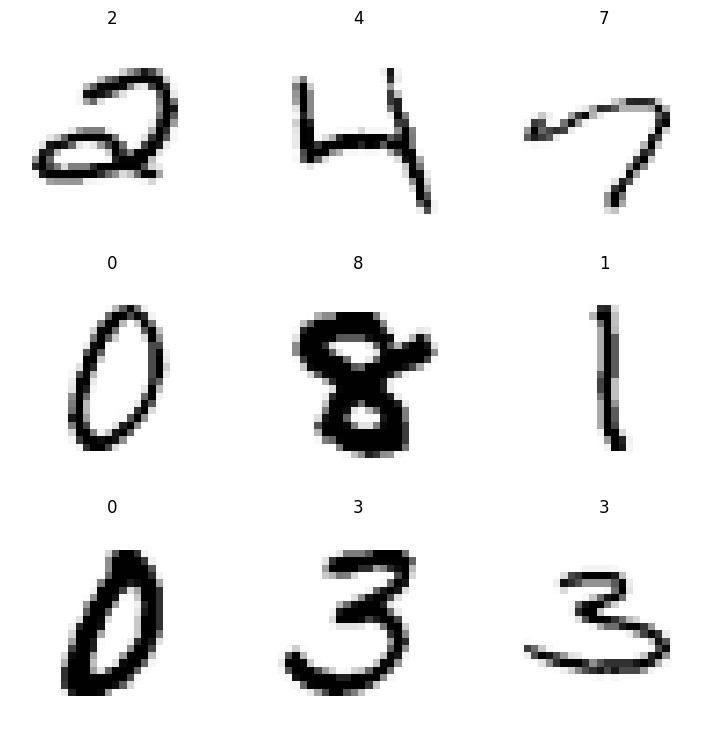

In [53]:
def get_dls(bs=128):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(
        path, 
        bs=bs,
        num_workers=4,
        pin_memory=True
    )

dls = get_dls()

dls.show_batch()

In [77]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    ).cuda()

In [69]:
from fastai.callback.hook import *

def fit(epochs=1, lr = 0.06):
    learn = Learner(
        dls, 
        simple_cnn(), 
        loss_func=F.cross_entropy,
        metrics=accuracy, 
        cbs=ActivationStats(with_hist=True)
    )
    learn.fit_one_cycle(epochs, lr)
    return learn

In [66]:
learn = fit()

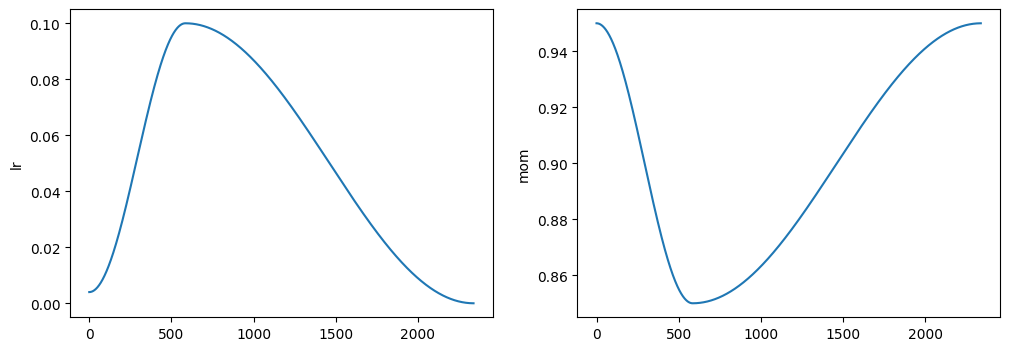

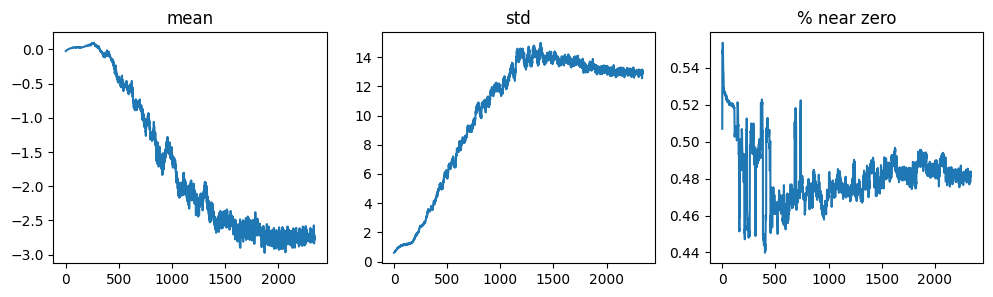

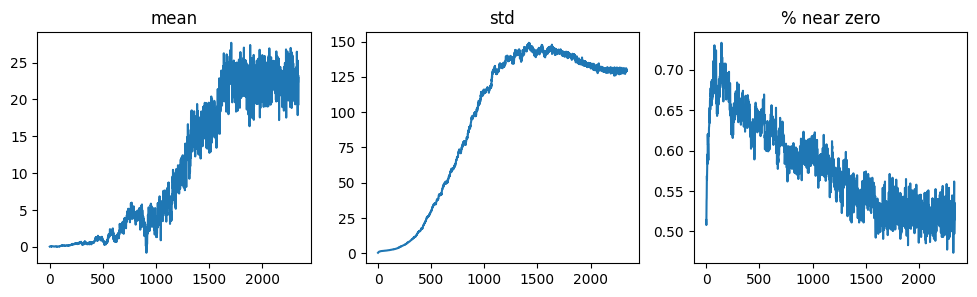

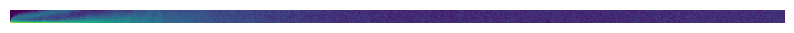

In [79]:
learn.recorder.plot_sched()
learn.activation_stats.plot_layer_stats(0)
learn.activation_stats.plot_layer_stats(-2)
learn.activation_stats.color_dim(-2)

In [78]:
learn = fit(5, 0.1)

c:\src\mrcn-zmnsk-playground\.venv\Lib\site-packages\fastai\callback\core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.115378,0.125734,0.965000,03:06
1,0.089563,0.100131,0.971600,03:00
2,0.059687,0.046051,0.985300,03:06
3,0.030150,0.028275,0.990100,03:21
4,0.016374,0.023960,0.992700,03:25
